# Практика 1

Предметная область: Игра Dota 2

Задача: предсказание победы по данным о первых 5 минутах игры

In [31]:
import numpy as np
import pandas as pd

import datetime

#### Чтения файла с признаками

In [32]:
my_path = r"C:\Users\sveta\Documents\7 семестр\МАД\Практическая 1. Предсказания победителя в онлайн-игре\data\features.csv"
features = pd.read_csv(my_path, index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки. Для этого нужно получать предсказания с помощью функции predict_proba. Она возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу. Вам нужны значения из второго столбца:
```python
pred = clf.predict_proba(X_test)[:, 1]
```

## Подход 1: градиентный бустинг "в лоб"

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [33]:
my_path = r"C:\Users\sveta\Documents\7 семестр\МАД\Практическая 1. Предсказания победителя в онлайн-игре\data\features.csv"
train = pd.read_csv(my_path, index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [34]:
count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

Обоснование пропусков:
    
- first_blood_player2 (второй игрок) - первое убийство может быть совершено одним игроком, происходит в 45% случаев
- radiant_flying_courier_time (время приобретения предмета flying_courier) - в 28% случаев команда не покупает flying_courier
- dire_flying_courier_time - аналогично radiant_flying_courier_time, процент почти тот же 26,8%.
- first_blood_time (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры.
- first_blood_team (команда, пролившая первую кровь) - процент совпадает с first_blood_time - 20%.
- first_blood_player1 (игрок, причастный к событию) - процент совпадает с first_blood_time - 20%.
- dire_bottle_time (время первого приобретения командой предмета bottle) - в 16,6% случаев команда не приобретает это в первые 5 минут игры.
- radiant_bottle_time - процент почти совпадает с dire_bottle_time ~ 16%.
- radiant_first_ward_time (время установки командой первого "наблюдателя") - очень редкое явление - 1% случаев за первые 5 минут игры.
- dire_first_ward_time - очень редкое явление - 1% случаев за первые 5 минут игры.
- radiant_courier_time (время приобретения предмета courier) - очень редкое явление в первые 5 минут игры - 0.7% 
- dire_courier_time - - очень редкое явление в первые 5 минут игры - 0.7% 

3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [35]:
train.fillna(0, inplace=True)

4. Какой столбец содержит целевую переменную? Запишите его название.


In [36]:
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"]

5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества.

In [37]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). 

In [39]:
def score_gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n_estimators in [10, 20, 30, 50, 100]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

n_estimators=10
Score: 0.997
Time elapsed: 0:00:13.282314

n_estimators=20
Score: 0.999
Time elapsed: 0:00:22.255714

n_estimators=30
Score: 0.999
Time elapsed: 0:00:32.269833

n_estimators=50
Score: 0.999
Time elapsed: 0:00:53.526075

n_estimators=100
Score: 0.999
Time elapsed: 0:01:48.189902



<AxesSubplot:>

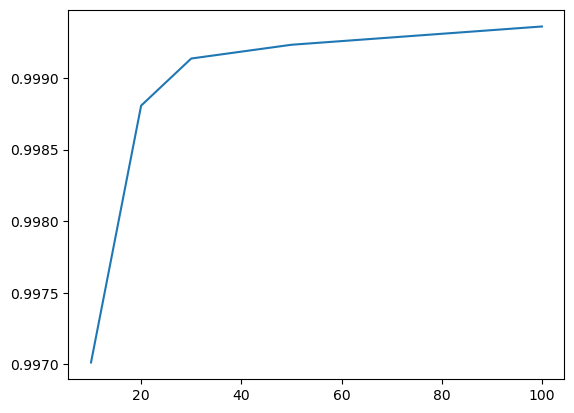

In [40]:
scores = score_gb(X_train, y_train)
scores.plot()

Долго ли настраивались классификаторы? 

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:32. Показатель метрики качества AUC-ROC в таком случае равен 0.999.

Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении? 

Модель очень быстро переобучилась. После 30 деревьев обучение уже не имело смысла. 

 Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов. Также можно уменьшить глубину деревьев (max_depth).

## Подход 2: логистическая регрессия

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?


2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).


4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?


6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?


##### Код для формирования "мешка слов" по героям
```python
# N — количество различных героев в выборке
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
```

## Проверка финальной модели

После того как вы провели все эксперименты и выбрали лучшую модель, можете проверить ее качество на тестовых матчах. Выборка тестовых матчей собрана в файле `matches_test.jsonlines.bz2`. В отличие от основного набора матчей, в тестовых матчах есть только та информация, которая известна на момент первых 5 игровых минут, результат матча — неизвестен. Таблица признаков для тестовых матчей — `features_test.csv`.

Для всех матчей из тестового набора предскажите вероятность победы Radiant, запишите предсказания в CSV файл с колонками `match_id` (идентификатор матча) и `radiant_win` — предсказанная вероятность. Файл с предсказаниями должен выглядеть примерно следующим образом:

```
match_id,radiant_win
1,0.51997370502
4,0.51997370502
15,0.51997370502
...
```



### Что еще попробовать?

Разумеется, можно попробовать еще очень много разных идей, которые помогут вам получить еще более высокий результат. Вот лишь несколько возможных вариантов:
1. Про каждого из игроков есть достаточно много показателей: максимальный опыт, число смертей и т.д. (см. список выше). Можно попробовать просуммировать или усредних их, получив агрегированные показатели для всей команды.
2. В сырых данных (файл matches.jsonlines.bz2) содержится очень много информации, которую мы пока не использовали. Вы можете, например, составить "мешки слов" для покупок различных предметов (то есть кодировать информацию о том, сколько раз каждая команда покупала тот или иной предмет). Обратите внимание, что при этом вы можете получить слишком большое количество признаков, для которых может иметь смысл сделать понижение размерности с помощью метода главных компонент.
3. Можно сформировать признаки про изменения способностей героев в течение матча (ability_upgrades).
4. В этом задании используются только градиентный бустинг и логистическая регрессия — но ведь мы изучали и другие модели! Можно попробовать метод k ближайших соседей, SVM, случайный лес и так далее.